In [3]:
!pip install ultralytics
!pip install albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 27.5 MB/s eta 0:00:00


In [4]:
#Importing standard libraries
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import torch
import yaml
import shutil
import torch
import torch.nn.functional as F
from ultralytics import YOLO
from ultralytics.models.yolo.detect import DetectionTrainer
from ultralytics.utils import LOGGER
from sklearn.metrics import f1_score
import albumentations as A
from pathlib import Path
import zipfile
import os
import matplotlib.pyplot as plt
import random as random

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
# FUNCTION TO INCLUDE AUGMENTED IMAGES



def create_augmented_dataset(
    original_images_path,
    original_labels_path,
    output_dir,
    num_augmentations
):
    """
    Create augmented dataset and return the path to the new dataset

    Args:
        original_images_path: Path to original images
        original_labels_path: Path to original labels
        output_dir: Directory to save augmented dataset
        num_augmentations: Number of augmentations per image

    Returns:
        str: Absolute path to the augmented dataset directory
    """

    # Convert to absolute paths
    output_dir = os.path.abspath(output_dir)
    output_images_dir = os.path.join(output_dir, 'images')
    output_labels_dir = os.path.join(output_dir, 'labels')

    # Create output directories if they don't exist
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)

    # Define augmentation pipeline
    transform = A.Compose([
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, alpha_coef=0.1, p=0.4),
        A.RandomRain(brightness_coefficient=0.8, drop_width=1, blur_value=3, p=0.3),
        A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.3, brightness_coeff=1.5, p=0.2),
        A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.5, p=0.2),
        A.MotionBlur(blur_limit=7, p=0.3),
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
        A.GaussNoise(var_limit=(10, 50), p=0.5),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8,8), p=0.3),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
    ])

    # First, copy original dataset
    image_files = [f for f in os.listdir(original_images_path) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

    # Copy original images and labels
    for img_file in image_files:
        # Copy original image
        shutil.copy2(
            os.path.join(original_images_path, img_file),
            os.path.join(output_images_dir, img_file)
        )

        # Copy corresponding label file (assuming same name, different extension)
        label_file = Path(img_file).stem + '.txt'  # Adjust extension if needed
        if os.path.exists(os.path.join(original_labels_path, label_file)):
            shutil.copy2(
                os.path.join(original_labels_path, label_file),
                os.path.join(output_labels_dir, label_file)
            )

    # Create augmented images and copy labels
    for idx, img_file in enumerate(image_files):
        img_path = os.path.join(original_images_path, img_file)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Failed to load image: {img_file}")
            continue

        # Get corresponding label file
        label_file = Path(img_file).stem + '.txt'

        # Create augmented versions
        for aug_idx in range(num_augmentations):
            # Create augmented image
            augmented = transform(image=img)
            aug_img = augmented['image']

            # Generate new filename
            base_name = Path(img_file).stem
            aug_img_name = f"{base_name}_aug_{aug_idx}{Path(img_file).suffix}"
            aug_label_name = f"{base_name}_aug_{aug_idx}.txt"

            # Save augmented image
            cv2.imwrite(
                os.path.join(output_images_dir, aug_img_name),
                aug_img
            )

            # Copy corresponding label file with new name
            if os.path.exists(os.path.join(original_labels_path, label_file)):
                shutil.copy2(
                    os.path.join(original_labels_path, label_file),
                    os.path.join(output_labels_dir, aug_label_name)
                )

        # Print progress
        if (idx + 1) % 10 == 0:
            print(f"Processed {idx + 1}/{len(image_files)} original images")

    # Count total images in new dataset
    final_count = len(os.listdir(output_images_dir))
    print(f"Augmentation complete. Total images in new dataset: {final_count}")
    print(f"Dataset path: {output_dir}")

    return output_dir



/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.3 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Augmentation

In [8]:
original_images = ""
original_labels = "/kaggle/working/original/labels"
output_directory = "/kaggle/working/augmented_dataset"

dataset_path = "/kaggle/input/sesame-zipped2/sesame-weed-detection-competition/labeled"
train_images = os.path.join(dataset_path, "images")
# val_images = "/content/drive/MyDrive/sesame-weed-detection-competition/sesame-weed-detection-competition/test/images"
labels_dir = os.path.join(dataset_path, "labels")
output_dir = "/kaggle/working/augmented_dataset"
# Create augmented dataset and get the path
augmented_dataset_path = create_augmented_dataset(
    train_images,
    labels_dir,
    output_dir,
    num_augmentations=5
)

Processed 10/200 original images
Processed 20/200 original images
Processed 30/200 original images
Processed 40/200 original images
Processed 50/200 original images
Processed 60/200 original images
Processed 70/200 original images
Processed 80/200 original images
Processed 90/200 original images
Processed 100/200 original images
Processed 110/200 original images
Processed 120/200 original images
Processed 130/200 original images
Processed 140/200 original images
Processed 150/200 original images
Processed 160/200 original images
Processed 170/200 original images
Processed 180/200 original images
Processed 190/200 original images
Processed 200/200 original images
Augmentation complete. Total images in new dataset: 1200
Dataset path: /kaggle/working/augmented_dataset


In [7]:

zip_path = "/kaggle/input/sesame-zipped2"
extract_to = "/kaggle/input/sesame-zipped2/sesame-weed-detection-competition"

# Extract ZIP if it hasn't been extracted yet
if not os.path.exists(extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("ZIP file extracted successfully!")
else:
    print("ZIP file already extracted.")

ZIP file already extracted.


Training Model

In [12]:


#Function for calculating F1 loss
def f1_loss(y_true, y_pred):
    tp = torch.sum(y_true * y_pred)
    fp = torch.sum((1 - y_true) * y_pred)
    fn = torch.sum(y_true * (1 - y_pred))

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)

    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return 1 - f1

#Function for calculating giou loss
def giou_loss(pred_boxes, target_boxes):
    iou = bbox_iou(pred_boxes, target_boxes, GIoU=True)
    return 1 - iou

#class defined to incorporate our own loss function into yolo architecture
class CustomDetectionTrainer(DetectionTrainer):
    def get_loss_and_metrics(self, batch, training=True):
        loss = torch.zeros(4, device=self.device)
        pred_distri, pred_scores = self.model(batch['img'])
        self.loss.preprocess(batch['batch_idx'], batch['cls'], batch['bboxes'])
        loss_items = self.loss(batch['batch_idx'], pred_distri, pred_scores, batch['cls'], batch['bboxes'])
        yolo_loss = sum(loss_items)
        loss += yolo_loss

        if training:
            cls_preds = pred_scores[0] if isinstance(pred_scores, list) else pred_scores
            cls_targets = batch['cls']
            if len(cls_targets.shape) == 1:
                cls_targets = F.one_hot(cls_targets.long(), num_classes=self.model.nc).float()
            f1 = f1_loss(cls_targets, cls_preds.sigmoid())
            pred_boxes = self.model.decode(pred_distri)
            giou = giou_loss(pred_boxes, batch['bboxes'])
            loss = 0.2 * f1 + 0.2 * giou + 0.6 * yolo_loss
        
        return loss, loss_items

def optimise_f1_score(true_labels: np.ndarray, pred_labels: np.ndarray):
    best_med_th = 0.5
    true_bools = [tl == 1 for tl in true_labels]
    micro_thresholds = (np.array(range(-45, 15)) / 100) + best_med_th
    f1_results = []
    
    for th in micro_thresholds:
        pred_bools = [pl > th for pl in pred_labels]
        test_f1 = f1_score(true_bools, pred_bools, average="macro", zero_division=0)
        f1_results.append(test_f1)
    
    best_f1_idx = np.argmax(f1_results)
    return micro_thresholds[best_f1_idx]

def train_model(model):
    dataset_path = "/kaggle/working/augmented_dataset"
    train_images = os.path.join(dataset_path, "images")
    val_images = "/kaggle/input/sesame-zipped2/sesame-weed-detection-competition/test/images"
    labels_dir = os.path.join(dataset_path, "labels")
    
    yaml_file = os.path.join("/kaggle/working", "dataset.yaml")
    dataset_yaml = {"path": dataset_path, "train": train_images, "val": val_images, "nc": 2, "names": ["crop", "weed"]}
    with open(yaml_file, "w") as file:
        yaml.dump(dataset_yaml, file, default_flow_style=False)
    
    model.trainer = CustomDetectionTrainer
    results = model.train(data=yaml_file, epochs=20, batch=16, imgsz=640, device='cuda' if torch.cuda.is_available() else 'cpu')
    return model

def self_training_loop(model, labeled_dir, unlabeled_dir, iterations=2):
    labeled_image_paths = glob(os.path.join(labeled_dir, "*.jpg"))
    unlabeled_image_paths = glob(os.path.join(unlabeled_dir, "*.jpg"))
    model = train_model(model)
    for iteration in range(iterations):
        remaining_unlabeled_images = []
        unlabeled_data = []
        selected_data = []
        print(f"Starting iteration {iteration + 1}...")

        for image_path in unlabeled_image_paths:
            results = model(image_path)
            if results and len(results) > 0:
                result = results[0]
                if result.boxes and result.boxes.xyxy.shape[0] > 0:
                    bboxes = result.boxes.xyxy.cpu().numpy()
                    classes = result.boxes.cls.cpu().numpy().reshape(-1, 1)
                    confidences = result.boxes.conf.cpu().numpy().reshape(-1, 1)
                    if bboxes.size > 0:
                        image_data = np.hstack((classes, bboxes))
                        unlabeled_data.append((image_path, image_data, confidences))
        
        sorted_unlabeled_data = sorted(unlabeled_data, key=lambda x: np.max(x[2]) if len(x[2]) > 0 else 0, reverse=True)
        
        if len(sorted_unlabeled_data) > 0:
            true_labels = np.array([1] * len(sorted_unlabeled_data))
            pred_labels = np.array([np.max(x[2]) for x in sorted_unlabeled_data])
            f1_threshold = optimise_f1_score(true_labels, pred_labels)
            selected_data = [x for x in sorted_unlabeled_data if np.max(x[2]) > f1_threshold]
        
        for r, _, _ in sorted_unlabeled_data:
            remaining_unlabeled_images.append(r)
        
        for image_path, image_data, _ in selected_data:
            image_name = os.path.basename(image_path)
            new_image_path = os.path.join(labeled_dir, image_name)
            shutil.copy(image_path, new_image_path)
            label_file = image_path.replace(".jpg", ".txt")
            new_label_path = os.path.join(labeled_dir, os.path.basename(label_file))
            if os.path.exists(label_file):
                shutil.copy(label_file, new_label_path)
            else:
                np.savetxt(new_label_path, image_data, fmt="%.6f")
        
        unlabeled_image_paths = remaining_unlabeled_images
        model = train_model(model)
        print(f"Iteration {iteration + 1} completed.")

    print("Self-training process finished!")

model = YOLO("yolov9c.pt")
labeled_dir = "/kaggle/working/augmented_dataset"
unlabeled_dir = "/kaggle/input/sesame-zipped2/sesame-weed-detection-competition/unlabeled"
self_training_loop(model, labeled_dir, unlabeled_dir)


Ultralytics 8.3.71 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/kaggle/working/dataset.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

train: Scanning /kaggle/working/augmented_dataset/labels.cache... 1200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1200/1200 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/input/sesame-zipped2/sesame-weed-detection-competition/test/labels... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 388.15it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/sesame-zipped2/sesame-weed-detection-competition/test is not writeable, cache not saved.


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      12.6G      1.666      2.228      1.959         85        640: 100%|██████████| 75/75 [01:09<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         50         74      0.121      0.368     0.0965     0.0303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      12.1G      1.787       1.97      1.978         66        640: 100%|██████████| 75/75 [01:08<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         50         74      0.346      0.288      0.306      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20        12G      1.755      1.966      1.961         56        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         50         74      0.135      0.489      0.189     0.0727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20        12G      1.667       1.79      1.886         73        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         50         74      0.629      0.622      0.639      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20        12G      1.676      1.719      1.873         54        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         50         74      0.711       0.68      0.746      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      11.9G      1.588      1.628      1.809         41        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         50         74      0.571      0.489      0.426      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20        12G      1.551      1.547      1.772         40        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         50         74       0.73      0.594      0.682      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20        12G      1.498       1.43      1.709         44        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         50         74      0.829      0.656      0.841      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20        12G      1.468      1.403      1.729         63        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         50         74      0.817      0.766      0.867      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20        12G      1.463      1.397      1.703         63        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]

                   all         50         74      0.805      0.689      0.841      0.506


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20        12G      1.441      1.353       1.83         25        640: 100%|██████████| 75/75 [01:08<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         50         74      0.869      0.842       0.91       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20        12G      1.386      1.216      1.796         17        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         50         74      0.759      0.772      0.831      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20        12G      1.309      1.158      1.712         38        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]

                   all         50         74       0.85       0.72      0.827      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20        12G       1.28      1.108      1.699         19        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]

                   all         50         74      0.794      0.724      0.848      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20        12G      1.228      1.024      1.636         29        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         50         74       0.81      0.777      0.863      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20        12G      1.195     0.9856      1.617         18        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         50         74      0.817      0.819      0.882      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20        12G      1.192     0.9824      1.597         24        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         50         74       0.84      0.696      0.853      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20        12G      1.165     0.9157      1.595         23        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         50         74       0.74      0.817      0.863      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20        12G      1.102     0.8783      1.518         35        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]

                   all         50         74      0.854      0.681      0.846      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20        12G      1.054     0.8194      1.509         19        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         50         74      0.771      0.856      0.879      0.584



20 epochs completed in 0.394 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 51.6MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.71 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv9c summary (fused): 384 layers, 25,320,790 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]


                   all         50         74       0.77      0.856      0.879      0.582
                  crop         24         42      0.844      0.899      0.934      0.633
                  weed         26         32      0.697      0.812      0.824      0.532


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 17.5ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train3
Starting iteration 1...

image 1/1 /kaggle/input/sesame-zipped2/sesame-weed-detection-competition/unlabeled/agri_0_5225_jpeg.rf.ab0d818fca3b3b0ef3411dea1a56000f.jpg: 640x640 1 weed, 21.8ms
Speed: 4.0ms preprocess, 21.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/sesame-zipped2/sesame-weed-detection-competition/unlabeled/agri_0_2390_jpeg.rf.b4af55b63fe3ad51e5ccaa7fae52a15a.jpg: 640x640 1 weed, 21.8ms
Speed: 2.5ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/sesame-zipped2/sesame-weed-detection-competition/unlabeled/agri_0_2633_jpeg.rf.80320a4fd05d32f7fae265c2d09ef7c4.jpg: 640x640 24 crops, 21.9ms
Speed: 2.3ms preprocess, 21.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/sesame-zipped2/sesame-weed-detection-competi

train: Scanning /kaggle/working/augmented_dataset/labels.cache... 1200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1200/1200 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/input/sesame-zipped2/sesame-weed-detection-competition/test/labels... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 351.60it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/sesame-zipped2/sesame-weed-detection-competition/test is not writeable, cache not saved.


Plotting labels to runs/detect/train32/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train32
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      12.1G      1.596      1.454      1.866         66        640: 100%|██████████| 75/75 [01:08<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         50         74      0.783      0.779      0.836      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      12.1G      1.552      1.408      1.827         56        640: 100%|██████████| 75/75 [01:07<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         50         74      0.786       0.74      0.835      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      12.1G      1.489       1.35      1.768         73        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         50         74      0.821      0.736      0.836      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      12.1G      1.468      1.295      1.737         54        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         50         74      0.771      0.839      0.866      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20        12G      1.412      1.251      1.711         41        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         50         74      0.729      0.823      0.839      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      12.1G      1.405      1.225      1.681         40        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]

                   all         50         74      0.837      0.712      0.825      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      12.1G      1.355      1.134      1.623         44        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         50         74      0.702      0.812      0.847      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      12.1G      1.305      1.136      1.634         63        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         50         74       0.73      0.821      0.846      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20        12G      1.325      1.142      1.627         63        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         50         74      0.835      0.869      0.878      0.557


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      12.1G      1.238      1.057      1.657         25        640: 100%|██████████| 75/75 [01:08<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         50         74      0.777      0.831      0.863      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      12.1G      1.166     0.9516      1.604         17        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         50         74      0.819      0.787        0.9      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      12.1G      1.149     0.9237      1.606         38        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         50         74      0.878      0.705      0.839      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20        12G       1.12     0.8984      1.568         19        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         50         74      0.793      0.855      0.874      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      12.1G      1.076     0.8333      1.533         29        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         50         74      0.849      0.839      0.897      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      12.1G      1.068     0.8259       1.51         18        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         50         74        0.8      0.837      0.873      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      12.1G      1.037      0.805      1.472         24        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         50         74      0.805      0.899      0.901      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20        12G      1.013     0.7634      1.474         23        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         50         74      0.859      0.844      0.895      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      12.1G     0.9735     0.7294      1.419         35        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         50         74      0.879      0.809      0.914      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      12.1G     0.9401     0.6925      1.407         19        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         50         74      0.871      0.807      0.914      0.601



20 epochs completed in 0.394 hours.
Optimizer stripped from runs/detect/train32/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/train32/weights/best.pt, 51.6MB

Validating runs/detect/train32/weights/best.pt...
Ultralytics 8.3.71 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv9c summary (fused): 384 layers, 25,320,790 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


                   all         50         74      0.879       0.81      0.914      0.615
                  crop         24         42      0.946       0.81      0.968      0.669
                  weed         26         32      0.812       0.81       0.86       0.56


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 17.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train32
Iteration 1 completed.
Starting iteration 2...

image 1/1 /kaggle/input/sesame-zipped2/sesame-weed-detection-competition/unlabeled/agri_0_8007_jpeg.rf.64aab9b135088ebcd38a908ee8eb3cf2.jpg: 640x640 1 crop, 23.7ms
Speed: 2.5ms preprocess, 23.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/sesame-zipped2/sesame-weed-detection-competition/unlabeled/agri_0_6717_jpeg.rf.eb4842a453d11c7954679e114005b61c.jpg: 640x640 1 crop, 22.0ms
Speed: 2.3ms preprocess, 22.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/sesame-zipped2/sesame-weed-detection-competition/unlabeled/agri_0_4519_jpeg.rf.3669ede317c0131d84809b96b549ef09.jpg: 640x640 2 crops, 22.1ms
Speed: 2.4ms preprocess, 22.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/sesame-zipped2/sesame

train: Scanning /kaggle/working/augmented_dataset/labels.cache... 1200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1200/1200 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/input/sesame-zipped2/sesame-weed-detection-competition/test/labels... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 381.48it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/sesame-zipped2/sesame-weed-detection-competition/test is not writeable, cache not saved.


Plotting labels to runs/detect/train322/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train322
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      12.1G      1.271      1.045      1.574         56        640: 100%|██████████| 75/75 [01:07<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         50         74      0.804      0.823      0.865      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      12.1G      1.258      1.067      1.563         73        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         50         74      0.767      0.867      0.859      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      12.1G      1.271      1.023      1.562         54        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]

                   all         50         74      0.787      0.871      0.865      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      12.1G      1.231      1.019      1.547         41        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         50         74       0.91      0.688      0.827      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      12.1G      1.251      1.006      1.548         40        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         50         74      0.741      0.879      0.868      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      12.1G      1.196     0.9549      1.486         44        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         50         74      0.907      0.734      0.882      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      12.1G      1.163     0.9623      1.509         63        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         50         74       0.79      0.859      0.904        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      12.1G      1.176     0.9628      1.496         63        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         50         74      0.886      0.894      0.892      0.576


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      12.1G      1.063     0.8498      1.494         25        640: 100%|██████████| 75/75 [01:08<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         50         74      0.793      0.813      0.884      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      12.1G       1.03      0.793       1.47         17        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         50         74      0.813      0.871      0.864      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      12.1G      1.008     0.7696      1.473         38        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         50         74      0.939      0.727        0.9      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      12.1G     0.9632     0.7287      1.424         19        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         50         74        0.8       0.91      0.911      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      12.2G     0.9301     0.6862      1.398         29        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         50         74        0.8      0.876      0.897      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      12.1G     0.9321     0.6849      1.396         18        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         50         74       0.85      0.886      0.908      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      12.1G     0.9109     0.6681      1.366         24        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         50         74      0.889      0.874      0.925       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      12.1G     0.8822      0.643      1.357         23        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         50         74      0.882      0.881       0.91       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      12.1G     0.8533     0.6221      1.316         35        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         50         74       0.94      0.881      0.934      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      12.1G     0.8275     0.6027      1.314         19        640: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         50         74      0.935      0.854      0.911      0.605



20 epochs completed in 0.394 hours.
Optimizer stripped from runs/detect/train322/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/train322/weights/best.pt, 51.6MB

Validating runs/detect/train322/weights/best.pt...
Ultralytics 8.3.71 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv9c summary (fused): 384 layers, 25,320,790 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]


                   all         50         74      0.889      0.874      0.925      0.619
                  crop         24         42      0.935      0.905      0.964      0.665
                  weed         26         32      0.843      0.844      0.885      0.573


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 17.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train322
Iteration 2 completed.
Self-training process finished!


In [13]:
# ✅ Save Trained Model
torch.save(model.state_dict(), "/kaggle/working/model.pt")

**Inference**


In [1]:
precision = 0.889
recall = 0.874
mAP50_95=0.619
f1_score = 2 * (precision * recall) / (precision + recall)
print("F1 Score:", f1_score)
print("mAP50:95",mAP50_95)
print("PS Metric",0.5*f1_score+0.5*mAP50_95)

F1 Score: 0.8814361883153716
mAP50:95 0.619
PS Metric 0.7502180941576858



0: 640x640 2 weeds, 23.8ms
Speed: 2.8ms preprocess, 23.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


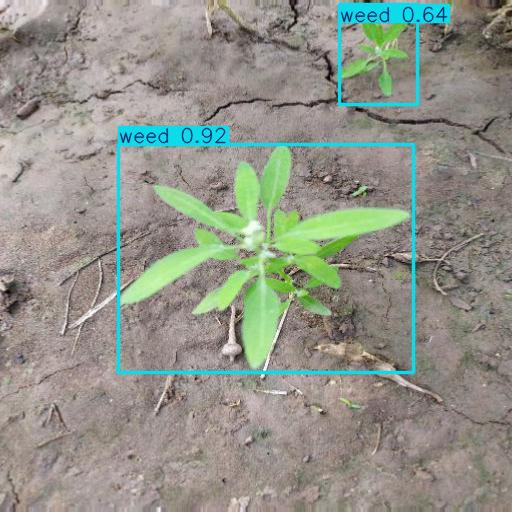

In [39]:

# Load the trained model (Replace with your model path)
# Ensure you replace "best.pt" with the actual path of your trained model
image_directory = "/kaggle/input/sesame-zipped2/sesame-weed-detection-competition/labeled/images"

# Get a list of all image files in the directory (JPG, PNG, etc.)
image_files = [f for f in os.listdir(image_directory) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Randomly select an image from the list
random_image = random.choice(image_files)

# Construct full image path
image_path = os.path.join(image_directory, random_image)
# Load the image

image = cv2.imread(image_path)

# Run inference
results = model(image)

# Show results
for r in results:
    # Plot the image with bounding boxes
    r.show()

    # Save the image with bounding boxes (Optional)
    r.save("output_image3.jpg")


0: 640x640 2 crops, 23.5ms
Speed: 3.2ms preprocess, 23.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


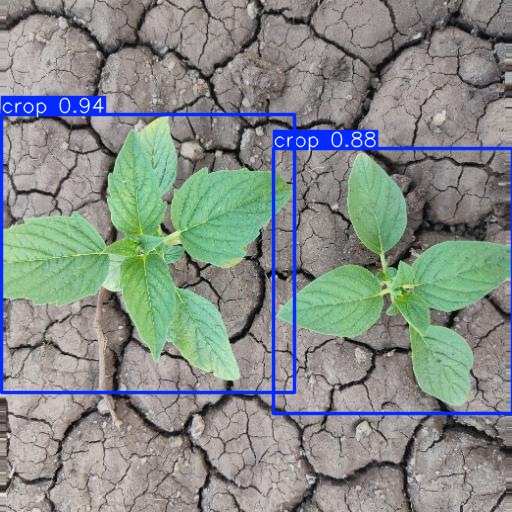

In [27]:

# Load the trained model (Replace with your model path)
# Ensure you replace "best.pt" with the actual path of your trained model
image_directory = "/kaggle/input/sesame-zipped2/sesame-weed-detection-competition/labeled/images"

# Get a list of all image files in the directory (JPG, PNG, etc.)
image_files = [f for f in os.listdir(image_directory) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Randomly select an image from the list
random_image = random.choice(image_files)

# Construct full image path
image_path = os.path.join(image_directory, random_image)
# Load the image

image = cv2.imread(image_path)

# Run inference
results = model(image)

# Show results
for r in results:
    # Plot the image with bounding boxes
    r.show()

    # Save the image with bounding boxes (Optional)
    r.save("output_image10.jpg")